In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import lightgbm as lgb
import random 
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_auc_score
import catboost as cat
import xgboost as xgb
import matplotlib as mpl
import optuna
import json

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

random.seed(42)
np.random.seed(42)

# Introduction

This kernel attempts to reflect my thought process while preparing for the competition. It involves many data science methods that are frequently applied on Kaggle competitions. The processes I conducted derived from my experience in data science as well as from this [book](https://www.amazon.com/Data-Analysis-Machine-Learning-Kaggle/dp/1801817472). I hope the viewer find this notebook useful. That being said, I'm new in the Kaggle Competitions, therefore I'm open for the suggestions and potential improvements. Thank you in advance.

# 1. The First Look

In [2]:
X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, 1:-1]
y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, -1]
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv").iloc[:, 1:]

X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


In [3]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00


In [4]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.566781,6.032761,20.00,23.00,26.00,30.00,94.00
person_income,39098.0,64060.460842,37955.828705,4000.00,42000.00,58000.00,75885.00,1900000.00
person_emp_length,39098.0,4.687068,3.868395,0.00,2.00,4.00,7.00,42.00
loan_amnt,39098.0,9251.466188,5576.254680,700.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,39098.0,10.661216,3.020220,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098.0,0.159573,0.091633,0.00,0.09,0.14,0.21,0.73
cb_person_cred_hist_length,39098.0,5.830707,4.072157,2.00,3.00,4.00,8.00,30.00


In [5]:
y.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [6]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
unique_counts_train = []
unique_counts_test = []

for categorical_feature in categorical_features:
    unique_counts_train.append(X[categorical_feature].nunique())
    unique_counts_test.append(test[categorical_feature].nunique())

categorical_counts = pd.DataFrame({"Categorical Features": categorical_features,
             "Unique_Counts_Train": unique_counts_train,
             "Unique_Counts_Test": unique_counts_test}).set_index("Categorical Features")

categorical_counts

,Unique_Counts_Train,Unique_Counts_Test
Categorical Features,,
person_home_ownership,4,4
loan_intent,6,6
loan_grade,7,7
cb_person_default_on_file,2,2


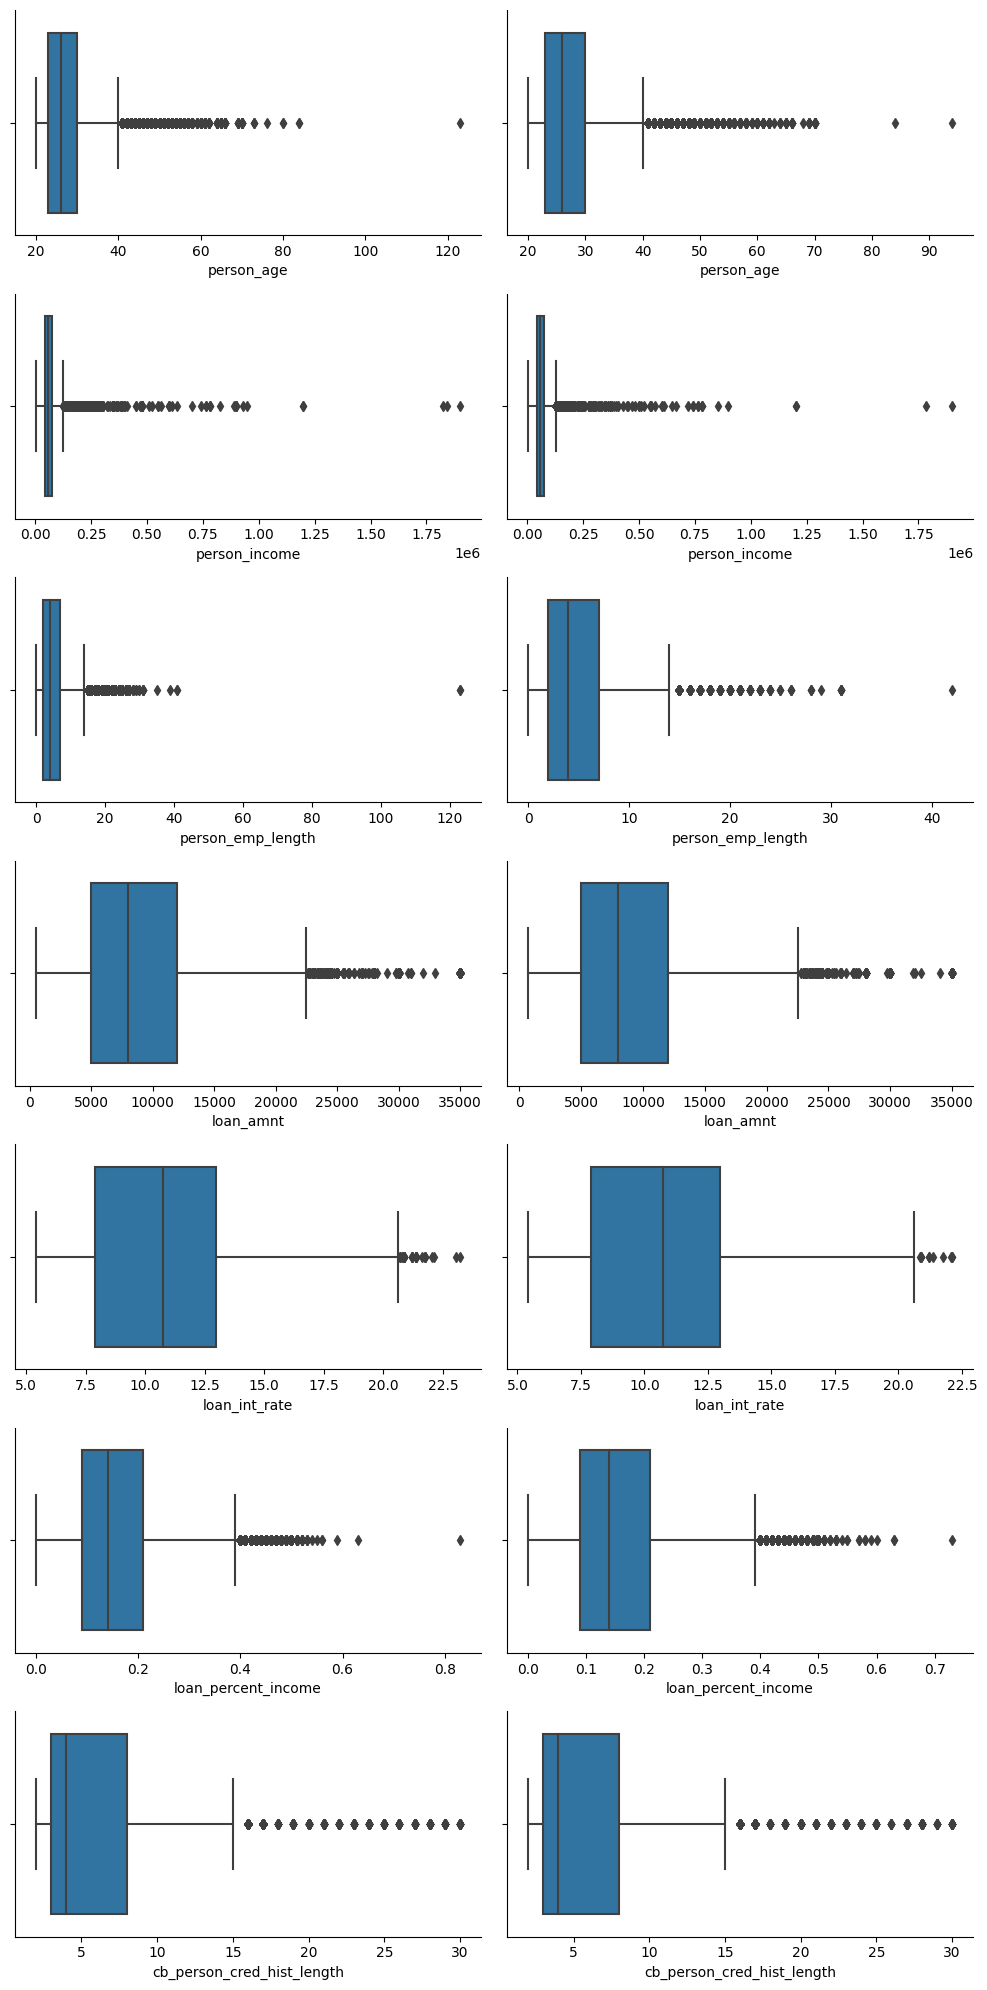

In [7]:
numerical_features = [column for column in X.columns if column not in categorical_features]
fig,ax = plt.subplots(ncols = 2,nrows = 7,figsize = (10,20))
row_no = 0

for numerical_feature in numerical_features:
    sns.boxplot(x = numerical_feature, data = X, ax = ax[row_no][0])
    sns.boxplot(x = numerical_feature, data = test, ax = ax[row_no][1])
    row_no+=1

plt.tight_layout()
fig.show()

The dataset of this challenge includes 58645 data points for training and 39098 data points for testing. It contains both categorical and numerical features. The training dataset is imbalanced meaning that data points having `loan_status = 0` lot more that the data points having `loan_status = 1`. We have to deal with this situation later on. The unique number of categorical features are identical in train and test sets and they have low cardinality. Since the cardinality is low, we can encode them in variety of ways without encountering `the curse of dimensionality` problem. Also the datasets do not contain any empty values therefore we don't need to to work on this area.

The train dataset has extreme data points in terms of `person_age` and `person_emph_length`. A person who lives 123 years might be possible but its unlikely. There is a possibility that the data was entered incorrectly, therefore I dropped that data point.

In [8]:
drop_idx = [
    X.loc[X.person_age == X.person_age.max()].index[0],
    X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
]

X = X.drop(drop_idx).reset_index(drop = True)
y = y.drop(drop_idx).reset_index(drop = True)

# 2. Adversarial Validation

In order to build a successful model, the train and test sets have to come from the same distributions. We can always plot all the features side by side for comparison but it is exhausting. Rather we can use `Adversarial Validation`.

In this method,

* The labels of the train and test datasets are dropped.
* The datasets are labeled as 0 and 1 respectively.
* The datasets are combined
* A model is trained on the combined data set.

If the model successfully predicts the fake labels then it means one of the following:

* There is a data leakage.
* The train and test sets are not coming from the same distributions.

The code below applies this process. I chose `lightgbm` due to its categorical feature support and fast convergence.

In [9]:
X['label'] = 0
test['label'] = 1

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for feature in categorical_features:
    X[feature] = X[feature].astype('category')
    test[feature] = test[feature].astype('category')

concat_data = pd.concat([X, test]).sample(frac=1, replace=False)
X_train, X_test, y_train, y_test = train_test_split(concat_data.iloc[:, :-1], concat_data['label'], test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("ROC AUC Score:", np.round(roc_auc,2))

[LightGBM] [Info] Number of positive: 31321, number of negative: 46871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 78192, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400565 -> initscore=-0.403110
[LightGBM] [Info] Start training from score -0.403110
ROC AUC Score: 0.5


ROC AUC score of 0.5 implies that train and test sets are identical.

<!-- # 3. Obtaining Baseline Performance -->

To obtain a baseline performance, I again used an untuned `LGBMClassifier`. To obtain a reliable performance data, I ran `StratifiedKFold` cross validation in 5 different random state settings. After that, I stored the results and commented the code below for the convenience.

In [10]:
# X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, 1:-1]
# y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, -1]

# drop_idx = [
#     X.loc[X.person_age == X.person_age.max()].index[0],
#     X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
# ]

# X = X.drop(drop_idx).reset_index(drop = True)
# y = y.drop(drop_idx).reset_index(drop = True)

# X['person_home_ownership'] = X['person_home_ownership'].astype('category')
# X['loan_intent'] = X['loan_intent'].astype('category')
# X['loan_grade'] = X['loan_grade'].astype('category')
# X['cb_person_default_on_file'] = X['cb_person_default_on_file'].astype('category')

# random_states = [1, 2, 3, 4, 5]
# baseline_scores = []
# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# base_params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting_type': 'gbdt',
#     'seed': 42,
#     'verbose': 0
# }

# for rnd_state in tqdm(random_states):
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_state)
#     for train_index, test_index in kf.split(X, y):
#         X_,y_ = X.loc[train_index],y.loc[train_index]
#         X_tst,y_tst = X.loc[test_index],y.loc[test_index]
#         X_train,X_val,y_train,y_val = train_test_split(X_,y_,random_state = rnd_state, stratify = y_)
        
#         train_dataset = lgb.Dataset(data = X_train,
#                                     label = y_train,
#                                     categorical_feature = categorical_features)
        
#         validation_dataset = lgb.Dataset(data = X_val,
#                                         label = y_val,
#                                         categorical_feature = categorical_features)
        
#         lgbm_model = lgb.train(base_params, train_dataset, num_boost_round=1000, valid_sets=[validation_dataset])
#         proba_preds = lgbm_model.predict(X_tst)
#         baseline_scores.append(roc_auc_score(y_tst, proba_preds))

# np.savetxt("lgbm_baseline.txt",baseline_scores)

# 3. Adding New Features

Creating more features can potentially improve the model performance because by doing so the model enables to capture nonlinear relationships between predictors. This procedure does not have strict rules. You can do a lot of thing using your imagination. That being said, the most frequent processes are 

1. Binning the numerical predictors
2. Creating meta features of rows and columns (sum, mean, median, std etc.)
3. Numerical operations using the predictors (summing, multiplying and dividing the predictors)

I used second and third method to create features. After that I ran the same untuned `lgbm` base model on the data.

In [11]:
# X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, 1:-1]
# y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, -1]

# drop_idx = [
#     X.loc[X.person_age == X.person_age.max()].index[0],
#     X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
# ]

# X = X.drop(drop_idx).reset_index(drop = True)
# y = y.drop(drop_idx).reset_index(drop = True)

# #creating meta features
# numerical_features = ['person_age', 'person_income','person_emp_length',"loan_amnt","loan_int_rate","loan_percent_income","cb_person_cred_hist_length"]
# X["Numeric Sum"] = X[numerical_features].sum(axis = 1)
# X["Numeric Mean"] = X[numerical_features].mean(axis = 1)
# X["Numeric Std"] = X[numerical_features].std(axis = 1)

# #creating features from the existing ones
# X['income_loan_ratio'] = X['person_income'] / X['loan_amnt']
# X['emp_length_to_age_ratio'] = X['person_emp_length'] / X['person_age']

# X['person_home_ownership'] = X['person_home_ownership'].astype('category')
# X['loan_intent'] = X['loan_intent'].astype('category')
# X['loan_grade'] = X['loan_grade'].astype('category')
# X['cb_person_default_on_file'] = X['cb_person_default_on_file'].astype('category')

# random_states = [1, 2, 3, 4, 5]
# feature_added_scores = []
# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# base_params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting_type': 'gbdt',
#     'seed': 42,
#     'verbose': 0
# }

# for rnd_state in tqdm(random_states):
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rnd_state)
#     for train_index, test_index in kf.split(X, y):
#         X_,y_ = X.loc[train_index],y.loc[train_index]
#         X_tst,y_tst = X.loc[test_index],y.loc[test_index]
#         X_train,X_val,y_train,y_val = train_test_split(X_,y_,random_state = rnd_state, stratify = y_)
        
#         train_dataset = lgb.Dataset(data = X_train,
#                                     label = y_train,
#                                     categorical_feature = categorical_features)
        
#         validation_dataset = lgb.Dataset(data = X_val,
#                                         label = y_val,
#                                         categorical_feature = categorical_features)
        
#         lgbm_model = lgb.train(base_params, train_dataset, num_boost_round=1000, valid_sets=[validation_dataset])
#         proba_preds = lgbm_model.predict(X_tst)
#         feature_added_scores.append(roc_auc_score(y_tst, proba_preds))

# np.savetxt("lgbm_feature_added_scores.txt",feature_added_scores)

# 4. Does Adding New Features Contribute to the Modeling?

While adding more features can be beneficial, if this process does not contribute to the model performance, it should be avoided. Simple is always better. Adding more redundant features only blurs the learning process. In this section I compared the performance outcomes of these models. I used bootstrapping to get the confidence interval.

In [12]:
lgbm_baseline = np.loadtxt("/kaggle/input/competition-prep/lgbm_baseline.txt")
lgbm_added_features = np.loadtxt("/kaggle/input/competition-prep/lgbm_feature_added_scores.txt")

* $H_0:$ The difference between the scores is not statistically significant. ($\mu_1 = \mu_2$)
* $H_A:$ The difference between the scores is not statistically significant. ($\mu_1 \neq \mu_2$)

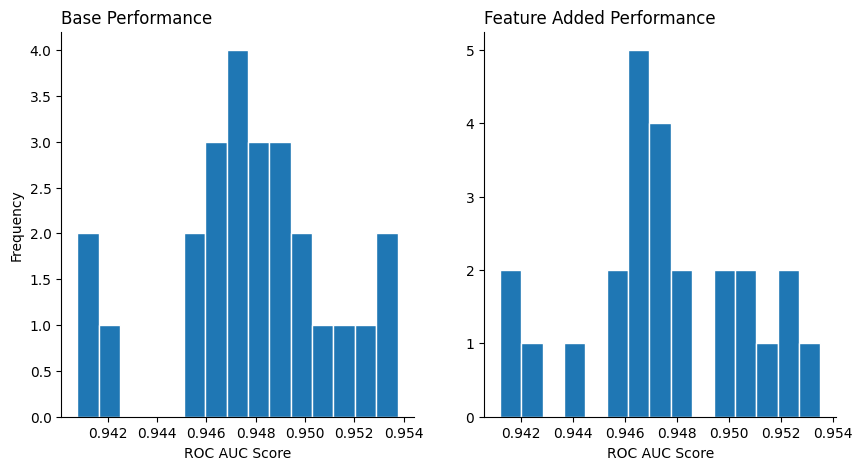

In [13]:
fig,ax = plt.subplots(ncols = 2,nrows = 1,figsize = (10,5))
ax[0].hist(lgbm_baseline, bins = 15, edgecolor = "white")
ax[1].hist(lgbm_added_features, bins = 15, edgecolor = "white")

ax[0].set_title("Base Performance", loc = "left")
ax[1].set_title("Feature Added Performance", loc = "left")

ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("ROC AUC Score")
ax[1].set_xlabel("ROC AUC Score")

fig.show()

In [14]:
diff = lgbm_added_features - lgbm_baseline
diff_simulation = stats.bootstrap((diff,),
                                 statistic = np.mean,
                                 n_resamples = 10000,
                                 random_state=42)
diff_simulation.confidence_interval

ConfidenceInterval(low=-0.0007969152725608606, high=5.593525018410446e-05)

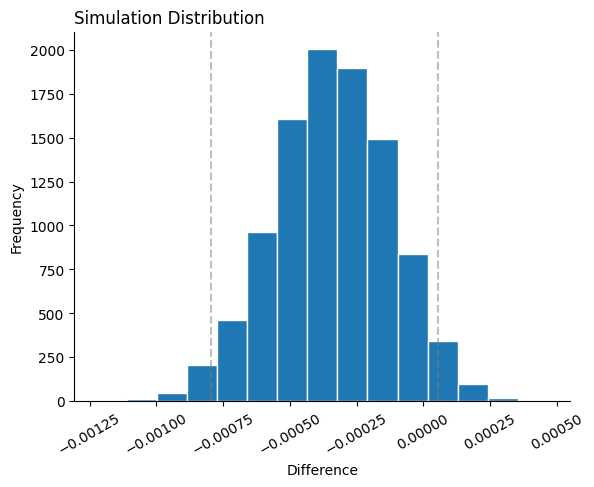

In [15]:
plt.figure()
plt.hist(diff_simulation.bootstrap_distribution,bins = 15,edgecolor = "white")
plt.axvline(diff_simulation.confidence_interval[0], linestyle = "--", alpha = 0.5, color = "grey")
plt.axvline(diff_simulation.confidence_interval[1], linestyle = "--", alpha = 0.5, color = "grey")
plt.title("Simulation Distribution", loc = "left")
plt.ylabel("Frequency")
plt.xlabel("Difference")
plt.xticks(rotation = 30)
plt.show()

**Conclusion:** Since 0 is in the confidence interval, we can conclude that we need more evidence to prove that adding new features contribute to the statistical modeling.

# 5. Model Optimization

In this section, I optimized the state of art algorithms for tabular data using `Optuna`. My goal is to compare these optimized models. Depending on the comparison results, we will have two options:

* If the models perform similarly, we could use a meta learner to improve the final performance.
* If one model beats all the others, then we could use it as our final prediction model.

Again, I ran the cells below and stored the results in elsewhere for the convenience. Feel free to uncomment these cells to get the parameters I obtained.  

## 5.1. LGBM Optimization

In [16]:
# !pip install optuna-integration[lightgbm]
# from optuna.integration import LightGBMPruningCallback


# X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, 1:-1]
# y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:, -1]

# drop_idx = [
#     X.loc[X.person_age == X.person_age.max()].index[0],
#     X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
# ]

# X = X.drop(drop_idx).reset_index(drop = True)
# y = y.drop(drop_idx).reset_index(drop = True)

# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# for feature in categorical_features:
#     X[feature] = X[feature].astype('category')

# X_,X_test,y_,y_test = train_test_split(X,y,stratify = y, random_state = 42, test_size = 0.15)
# X_train,X_val,y_train,y_val = train_test_split(X_,y_,stratify = y_, random_state = 42, test_size = 0.1)

# def objective(trial):
    
#     param = {
#         'objective': 'binary',  
#         'metric': 'auc',
#         'is_unbalance': 'true',
#         'verbosity': -1,  
#         'seed': 42,
#         'boosting_type': 'gbdt',  
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log = True),  
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log = True), 
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),  
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), 
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log = True),
#         'num_boost_round': trial.suggest_int("num_boost_round",10,5000)
#     }
    
    
#     dtrain = lgb.Dataset(X_train, label=y_train)
#     dval = lgb.Dataset(X_val,label = y_val)
    
    
#     gbm = lgb.train(
#         param, dtrain, 
#         valid_sets=[dval],  
#         callbacks=[LightGBMPruningCallback(trial, 'auc')]  
#     )
    
#     y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    
#     auc_score = roc_auc_score(y_test, y_pred)
    
#     return auc_score

# study = optuna.create_study(direction='maximize')  
# study.optimize(objective, n_trials=150, timeout=900) 

# best_params = study.best_params

# with open("lgbm_best_params.json", "w") as f:
#     json.dump(best_params, f, indent=4)

## 5.2. CatBoost Optimization

In [17]:
# X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,1:-1]
# y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,-1]
# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# drop_idx = [
#     X.loc[X.person_age == X.person_age.max()].index[0],
#     X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
# ]

# X = X.drop(drop_idx).reset_index(drop = True)
# y = y.drop(drop_idx).reset_index(drop = True)

# X_,X_test,y_,y_test = train_test_split(X,y,stratify = y, random_state = 42, test_size = 0.15)
# X_train,X_val,y_train,y_val = train_test_split(X_,y_,stratify = y_, random_state = 42, test_size = 0.1)

# def objective(trial):

#     param = {
#         'iterations': trial.suggest_int('iterations', 10, 5000),  
#         'depth': trial.suggest_int('depth', 4, 10),  
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0,log = True), 
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0,log = True),  
#         'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),  
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),  
#         'border_count': trial.suggest_int('border_count', 1, 255),  
#         'loss_function': 'Logloss',
#         'task_type': 'CPU',
#         'scale_pos_weight': (sum(y_train == 0) / sum(y_train == 1)),
#         'random_state': 42,
#         'early_stopping_rounds': 100,
#         'use_best_model':True,
#         'eval_metric':'AUC',
#         'cat_features': categorical_features
        
        
#     }

    

#     dtrain = cat.Pool(X_train,
#                       label = y_train,
#                       cat_features = categorical_features)

#     dval = cat.Pool(X_val,
#                    label = y_val,
#                    cat_features = categorical_features)

#     cat_model = cat.CatBoostClassifier(**param)
#     cat_model.fit(dtrain,
#                  eval_set = (dval))
                              

#     preds = cat_model.predict_proba(X_test)[:,1]
#     auc_score = roc_auc_score(y_test,preds)
#     return auc_score

# study = optuna.create_study(direction = "maximize")
# study.optimize(objective,n_trials = 100, timeout = 600)

# best_params = study.best_params

# with open("catboost_best_params.json", "w") as f:
#     json.dump(best_params, f, indent=4)

## 5.3. XGBoost Optimization

In [18]:
# X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,1:-1]
# y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,-1]

# drop_idx = [
#     X.loc[X.person_age == X.person_age.max()].index[0],
#     X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
# ]

# X = X.drop(drop_idx).reset_index(drop = True)
# y = y.drop(drop_idx).reset_index(drop = True)




# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# ohe_features = categorical_features[:-1]  


# ct = ColumnTransformer(
#     transformers=[
#         ('ohe', OneHotEncoder(), ohe_features),
#         ('oe', OrdinalEncoder(),["cb_person_default_on_file"])
#     ],
#     remainder='passthrough'  
# )


# X_transformed = ct.fit_transform(X)

# X_,X_test,y_,y_test = train_test_split(X_transformed,y,stratify = y, random_state = 42, test_size = 0.15)
# X_train,X_val,y_train,y_val = train_test_split(X_,y_,stratify = y_, random_state = 42, test_size = 0.1)

# def objective(trial):

#     param = {
#         'verbosity': 0,  
#         'objective': 'binary:logistic',  
#         'eval_metric': 'auc',
#         'tree_method': 'auto',
#         'max_delta_step': trial.suggest_int('max_delta_step', 0, 20),
#         'booster': 'gbtree',  
#         'lambda': trial.suggest_float('lambda', 1e-3, 10.0,log = True),  
#         'alpha': trial.suggest_float('alpha', 1e-3, 10.0,log = True),  
#         'eta': trial.suggest_float('eta', 1e-2, 1,log = True),  
#         'max_depth': trial.suggest_int('max_depth', 1, 50),  
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),  
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0), 
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 5000) ,
#         'scale_pos_weight': (sum(y_train == 0) / sum(y_train == 1)),
#         'random_state': 42
#     }

#     xgb_model = xgb.XGBClassifier(**param)
#     xgb_model.fit(X_train,y_train,
#                  eval_set=[(X_val, y_val)],
#                  early_stopping_rounds=100, verbose=False)

#     preds = xgb_model.predict_proba(X_test)[:,1]
#     auc_score = roc_auc_score(y_test,preds)

#     return auc_score

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective,n_trials = 150,timeout = 900)

# best_params = study.best_params

# with open("xgboost_best_params.json", "w") as f:
#     json.dump(best_params, f, indent=4)

# 6. Optimized Model Comparison

First I loaded the best parameters and combine them with the constant ones.

In [19]:
#load the optimized parameters for each model
with open("/kaggle/input/competition-prep/catboost_best_params.json", 'r') as f:
    cat_best_params = json.load(f)

with open("/kaggle/input/competition-prep/lgbm_best_params.json", 'r') as f:
    lgbm_best_params = json.load(f)

with open("/kaggle/input/competition-prep/xgboost_best_params.json", 'r') as f:
    xgb_best_params = json.load(f)


#complete the parameter dictionaries
lgbm_rest = {'objective': 'binary',  
        'metric': 'auc',
        'is_unbalance': 'true',
        'verbosity': -1,  
        'seed': 42,
        'boosting_type': 'gbdt'}

lgbm_best_params.update(lgbm_rest) 

cat_rest = {'loss_function': 'Logloss',
            'task_type': 'CPU',
            'scale_pos_weight': (sum(y_train == 0) / sum(y_train == 1)),
            'random_state': 42,
            'early_stopping_rounds': 100,
           'use_best_model':True,
           'eval_metric':'AUC',
            'cat_features': categorical_features}

cat_best_params.update(cat_rest)

xgb_rest = {'verbosity': 0,
            'objective': 'binary:logistic',
            'scale_pos_weight': (sum(y_train == 0) / sum(y_train == 1)),
            'random_state': 42,
            'eval_metric': 'auc',
            'tree_method': 'auto',
            'booster': 'gbtree',
          }

xgb_best_params.update(xgb_rest)

Then I prepared the training dataset for the models.

In [20]:
X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,1:-1]
y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,-1]

drop_idx = [
    X.loc[X.person_age == X.person_age.max()].index[0],
    X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
]

X = X.drop(drop_idx).reset_index(drop = True)
y = y.drop(drop_idx).reset_index(drop = True)

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
ohe_features = categorical_features[:-1]  


ct = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), ohe_features),
        ('oe', OrdinalEncoder(),["cb_person_default_on_file"])],remainder='passthrough')

X_xgboost = ct.fit_transform(X.copy())

for feature in categorical_features:
    X[feature] = X[feature].astype('category')

Finally, I trained all the models using `StratifiedKFold` cross validation.

In [21]:
# lgbm_performances = []
# random_states = [1,2,3,4,5]
# for rnd_state in tqdm(random_states):
#     skf = StratifiedKFold(n_splits = 5, random_state = rnd_state,shuffle = True)
#     for train_index, test_index in skf.split(X, y):
#         X_,y_ = X.loc[train_index],y.loc[train_index]
#         X_tst,y_tst = X.loc[test_index],y.loc[test_index]
#         X_train,X_val,y_train,y_val = train_test_split(X_,y_,random_state = rnd_state, stratify = y_)
        
#         dtrain = lgb.Dataset(X_train,label = y_train,
#                             categorical_feature = categorical_features)
#         dval = lgb.Dataset(X_val,label = y_val,
#                           categorical_feature = categorical_features)
        
#         gbm = lgb.train(lgbm_best_params,
#                        dtrain,
#                        valid_sets = [dval],
#                        )

#         preds = gbm.predict(X_tst, num_iteration=gbm.best_iteration)
#         auc_score = roc_auc_score(y_tst,preds)
#         lgbm_performances.append(auc_score)
        
# np.savetxt("lgbm_best_performances.txt",lgbm_performances)

In [22]:
# cat_performances = []

# random_states = [1,2,3,4,5]
# for rnd_state in tqdm(random_states):
#     skf = StratifiedKFold(n_splits = 5, random_state = rnd_state,shuffle = True)
    
#     for train_index, test_index in skf.split(X, y):
#         lgb_model = lgb.LGBMClassifier(**lgbm_best_params)
#         cat_model = cat.CatBoostClassifier(**cat_best_params)

#         X_,y_ = X.loc[train_index],y.loc[train_index]
#         X_tst,y_tst = X.loc[test_index],y.loc[test_index]
#         X_train,X_val,y_train,y_val = train_test_split(X_,y_,random_state = rnd_state, stratify = y_)
        
#         cat_model.fit(X_train,y_train,
#                      eval_set = [(X_val,y_val)])

#         cat_preds = cat_model.predict_proba(X_tst)[:,1]
#         cat_performances.append(roc_auc_score(y_tst,cat_preds))

# np.savetxt("cat_best_performaces.txt",cat_performances)

In [23]:
# xgb_performances = []

# random_states = [1,2,3,4,5]
# for rnd_state in tqdm(random_states):
#     skf = StratifiedKFold(n_splits = 5, random_state = rnd_state,shuffle = True)
    
#     for train_index, test_index in skf.split(X_xgboost, y):
#         xgb_model = xgb.XGBClassifier(**xgb_best_params)

#         X_,y_ = X_xgboost[train_index],y.loc[train_index]
#         X_tst,y_tst = X_xgboost[test_index],y.loc[test_index]
#         X_train,X_val,y_train,y_val = train_test_split(X_,y_,random_state = rnd_state, stratify = y_)

#         xgb_model.fit(X_train,y_train,
#                      eval_set = [(X_val,y_val)],
#                      early_stopping_rounds = 100)

#         xgb_preds = xgb_model.predict_proba(X_tst)[:,1]
#         xgb_performances.append(roc_auc_score(y_tst,xgb_preds))
        
# np.savetxt("xgb_best_performaces.txt",xgb_performances)

In [24]:
catboost_performance = np.loadtxt("/kaggle/input/competition-prep/cat_best_performaces.txt")
lgbm_performance = np.loadtxt("/kaggle/input/competition-prep/lgbm_best_performances.txt")
xgb_performance = np.loadtxt("/kaggle/input/competition-prep/xgb_best_performaces.txt")

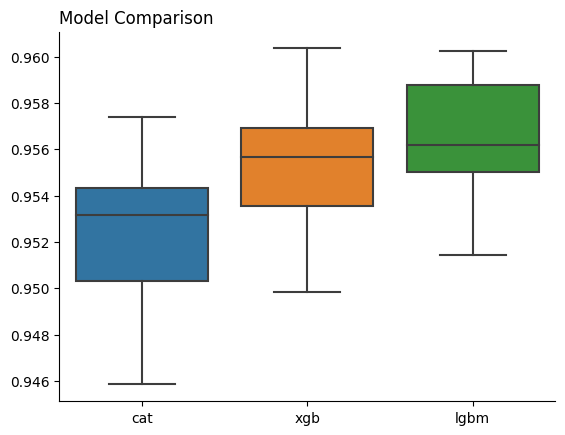

In [25]:
plt.figure()
sns.boxplot([catboost_performance,xgb_performance,lgbm_performance])
plt.xticks([0,1,2],["cat","xgb","lgbm"])
plt.title("Model Comparison", loc = "left")
plt.show()


In [26]:
test_results = stats.f_oneway(catboost_performance,xgb_performance,lgbm_performance)
print("ANOVA Results:")
print("Test statistic:", test_results[0])
print("P-value:", test_results[1])
print()
print(stats.tukey_hsd(catboost_performance,xgb_performance,lgbm_performance))

ANOVA Results:
Test statistic: 14.46517381860073
P-value: 5.238249541199847e-06

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.003     0.001    -0.005    -0.001
 (0 - 2)     -0.004     0.000    -0.005    -0.002
 (1 - 0)      0.003     0.001     0.001     0.005
 (1 - 2)     -0.001     0.415    -0.003     0.001
 (2 - 0)      0.004     0.000     0.002     0.005
 (2 - 1)      0.001     0.415    -0.001     0.003



From the boxplots and statistical tests, we can confidently say that `lgbm` model is better than the others. Therefore, we don't need to use a meta learner. We can opt for `lgbm` model as our final prediction model instead.

# 7. Final Training and Submission

In [27]:
X = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,1:-1]
y = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").iloc[:,-1]
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

drop_idx = [
    X.loc[X.person_age == X.person_age.max()].index[0],
    X.loc[X.person_emp_length == X.person_emp_length.max()].index[0]
]

X = X.drop(drop_idx).reset_index(drop = True)
y = y.drop(drop_idx).reset_index(drop = True)

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for feature in categorical_features:
    X[feature] = X[feature].astype('category')
    test[feature] = test[feature].astype('category')
    
dtrain = lgb.Dataset(X,label = y,categorical_feature = categorical_features)
lgb_model = lgb.train(lgbm_best_params,dtrain)
preds = lgb_model.predict(test.iloc[:,1:], num_iteration=lgb_model.best_iteration)
submission = pd.DataFrame({'id':test.iloc[:,0],
                          'loan_status':preds})
submission.to_csv('submission.csv',index = False)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


And that's all about it. Thank you for your time.